In [1]:
import tensorflow.keras as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D,MaxPooling3D,Dense,Flatten,Dropout
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import tanh
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import os

***CODE IMPLEMENTATION FOR THE 2012 RESEARCH PAPER***

In [3]:
image_height = 48
image_width = 64
frames = 13
classes = 2

dataset_path  = "" #fill the path to the training data


labels = {
    'Brawl' : 0,
    'Peace' : 1
}


def load_frames(video_path,frame_count=frames):
  cap = cv2.VideoCapture(video_path)
  frames  = []

  if not cap.isOpened():
    print("Error in opening video.")
    return None

  total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  if total_frames < frame_count:
    repeat_last_frame = True
  else:
    repeat_last_frame = False

  success, frame = cap.read()
  if not success:
    cap.release()
    return None

  frame = cv2.resize(frame,(image_width,image_height))
  frames.append(frame)

  for _ in range(frame_count - 1):
        success, frame = cap.read()
        if not success:
            break

        frame = cv2.resize(frame, (image_width, image_height))
        frames.append(frame)

  cap.release()

    # If the video has fewer frames, duplicate the last frame to make up for missing frames
  while len(frames) < frame_count:
      frames.append(frames[-1])

  return np.array(frames) / 255.0


def load_dataset(dataset_path,labels):
  X,y = [],[]
  for label,idx in labels.items():
    folder_path = os.path.join(dataset_path,label)
    for video_file in os.listdir(folder_path):
      video_path = os.path.join(folder_path,video_file)
      video_data = load_frames(video_path)

      if video_data is not None:
        X.append(video_data)
        y.append(idx)
  X = np.array(X)
  y = to_categorical(y,classes) # One hot encoding for categorical cross entropy loss
  #y = np.array(y) #continuous prediction
  return X,y

def build_3DCNN():

  model = Sequential([

      # First Convolutional Layer
      Conv3D(filters = 7,kernel_size=(7,7,7),activation="relu",padding="same",input_shape =(frames,image_height,image_width,3)),
      MaxPooling3D(pool_size=(2,2,2)),

      # Second Convolutional Layer
      Conv3D(filters = 50,kernel_size = (7,7,5),padding="same",activation="relu"),
      MaxPooling3D(pool_size = (2,2,2)),

      #Third Convolutional Layer
      Conv3D(filters = 10,kernel_size=(5,5,3),padding="same",activation="relu"),

      #Flatten features into 1-D vector
      Flatten(),

      # Fully connected layers
      Dense(100,activation="relu"),
      Dropout(0.55),

      # Output Layer
      Dense(classes,activation="softmax"),
  ])
  return model


In [4]:
X,y = load_dataset(dataset_path,labels)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,train_size = 0.8,random_state = 42)

In [14]:
model = build_3DCNN()

model.compile(
    optimizer = Adam(learning_rate=0.000095),
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

model.summary()

history = model.fit(
    X_train,y_train,
    epochs = 18,
    validation_data = (X_test,y_test)
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)                    │ (None, 13, 48, 64, 7)       │           7,210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 6, 24, 32, 7)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_4 (Conv3D)                    │ (None, 6, 24, 32, 50)       │          85,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 3, 12, 16, 50)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 3, 12, 16, 10)       │          37,510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 5760)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │         576,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             202 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 706,822 (2.70 MB)

 Trainable params: 706,822 (2.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.5350 - loss: 0.6932 - val_accuracy: 0.6187 - val_loss: 0.6834
Epoch 2/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.5726 - loss: 0.6798 - val_accuracy: 0.6156 - val_loss: 0.6613
Epoch 3/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.6503 - loss: 0.6464 - val_accuracy: 0.6844 - val_loss: 0.5978
Epoch 4/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.6937 - loss: 0.6053 - val_accuracy: 0.7312 - val_loss: 0.5371
Epoch 5/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.7218 - loss: 0.5571 - val_accuracy: 0.7344 - val_loss: 0.4969
Epoch 6/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.7832 - loss: 0.4809 - val_accuracy: 0.7937 - val_loss: 0.4588
Epoch 7/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.7896 - loss: 0.4479 - val_accuracy: 0.7625 - val_loss: 0.4870
Epoch 8/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.7746 - loss: 0.4543 - val_accuracy: 0.

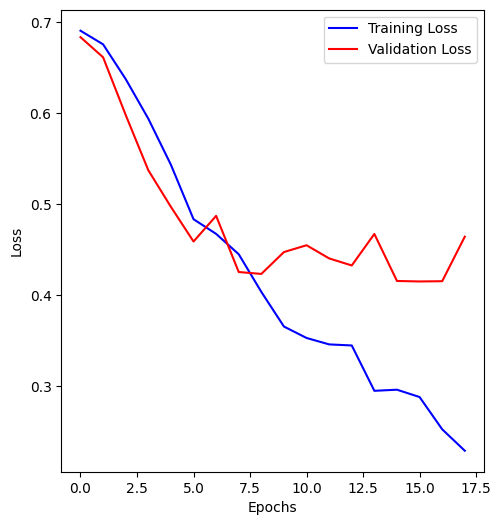

In [15]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(train_loss,label = "Training Loss",color = "blue")
plt.plot(val_loss,label = "Validation Loss",color = "red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

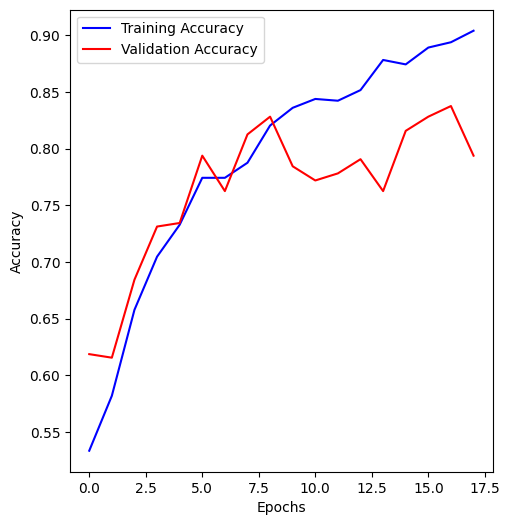

In [16]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(train_accuracy,label = "Training Accuracy",color = "blue")
plt.plot(val_accuracy,label = "Validation Accuracy",color = "red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


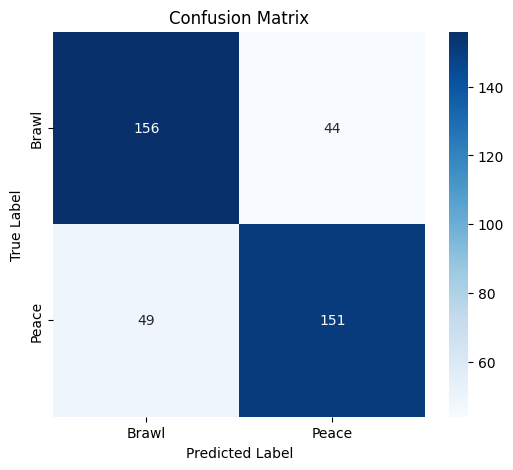

In [17]:
path = "" #fill the path to testing data
X_testing,y_testing = load_dataset(path,labels)

y_pred = model.predict(X_testing)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_testing, axis=1)

cm = confusion_matrix(y_true,y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels.keys(), yticklabels=labels.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [18]:
true_positive = cm[0,0]
false_positive = cm[0,1]
false_negative = cm[1,0]
true_negative = cm[1,1]

precision = true_positive/(true_positive+false_positive)
recall = true_positive/(true_positive+false_negative)
f1score = (2 * precision * recall) / (precision + recall)
accuracy = (true_positive + true_negative) / (true_positive+true_negative+false_negative+false_positive)

print(f"The model has a precision of {precision:.5f}, recall of {recall:.5f}, F1 Score of {f1score:.5f} and accuracy of {accuracy:.5f}")

The model has a precision of 0.78000, recall of 0.76098, F1 Score of 0.77037 and accuracy of 0.76750


In [19]:
model.save("breaking-bias-2012-balanced.h5")